Gemma 3
====

 * Gated model aggreement

![Gated Model License](../assets/hf-gated-model-license.png)

```bash
pip install --upgrade transformers  # required
```

### Inference using the pipeline

In [ ]:
import base64
from io import BytesIO
from PIL import Image
import torch
from transformers import pipeline

pipe = pipeline(
    "image-text-to-text",
    model="google/gemma-3-4b-it",
    device="cuda",
    torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [3]:
import base64
from io import BytesIO
from PIL import Image

image1 = Image.open("../samples/fruits-01.jpg")

def load_image_as_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

image1_base64 = load_image_as_base64(image1)

In [4]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image1_base64},
            {"type": "text", "text": "What fruits and vegetables do you see in this image?"}
        ]
    }
]

output = pipe(text=messages, max_new_tokens=200)
print(output[0]["generated_text"][-1]["content"])

Okay, let's take a look! 

In the image, I see:

*   **Blueberries**
*   **Cucumbers** (they are sliced)
*   **Raspberries** 

Would you like me to describe anything else about the image?


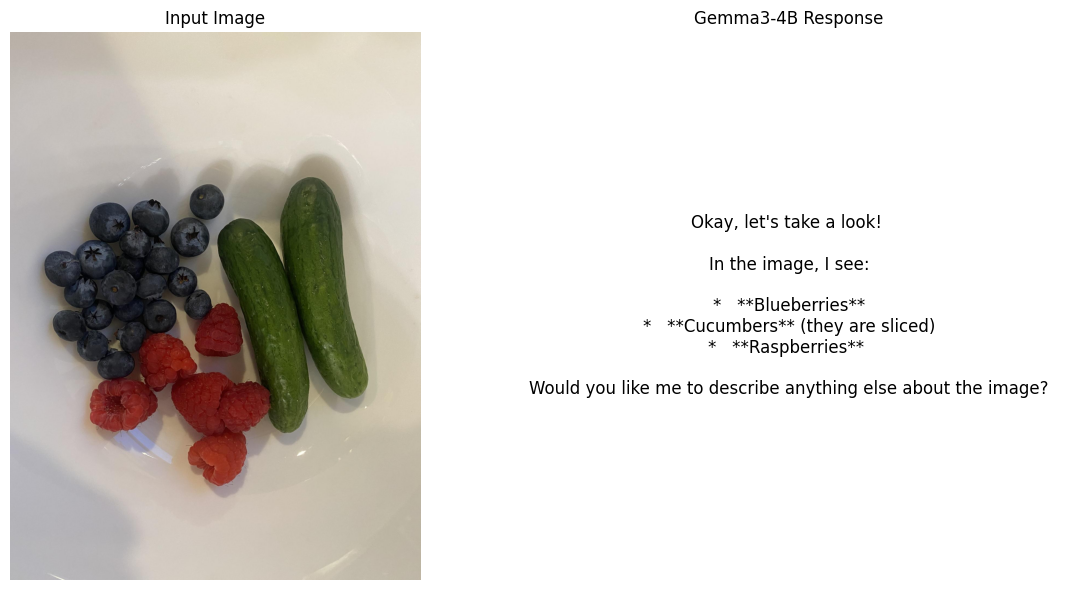

In [6]:
import matplotlib.pyplot as plt

response = output[0]["generated_text"][-1]["content"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image1)
axes[0].axis("off")
axes[0].set_title("Input Image")
axes[1].text(
    0.5, 0.5, response,
    fontsize=12, ha="center", va="center", wrap=True
)
axes[1].axis("off")
axes[1].set_title("Gemma3-4B Response")
plt.tight_layout()
plt.show()

### Directly inference with model

In [7]:
# pip install accelerate

from transformers import AutoProcessor, Gemma3ForConditionalGeneration

model_id = "google/gemma-3-4b-it"

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, device_map="auto"
).eval()

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [8]:
image2 = Image.open("../samples/plants.jpg")
image2_base64 = load_image_as_base64(image2)

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image2_base64},
            {"type": "text", "text": "Describe this image in detail."}
        ]
    }
]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]

decoded = processor.decode(generation, skip_special_tokens=True)
print(decoded)

/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Okay, here's a detailed description of the image:

**Overall Impression:**

The image showcases two potted plants displayed against a plain white wall. The plants are accented with stylish, gold-colored wire planters, creating a modern and slightly rustic aesthetic.

**Plants:**

*   **Plant 1 (Left):** This plant is a smaller, leafy green plant with a somewhat bushy appearance. It’s potted in a dark blue, cylindrical planter with a gold wire cage surrounding it


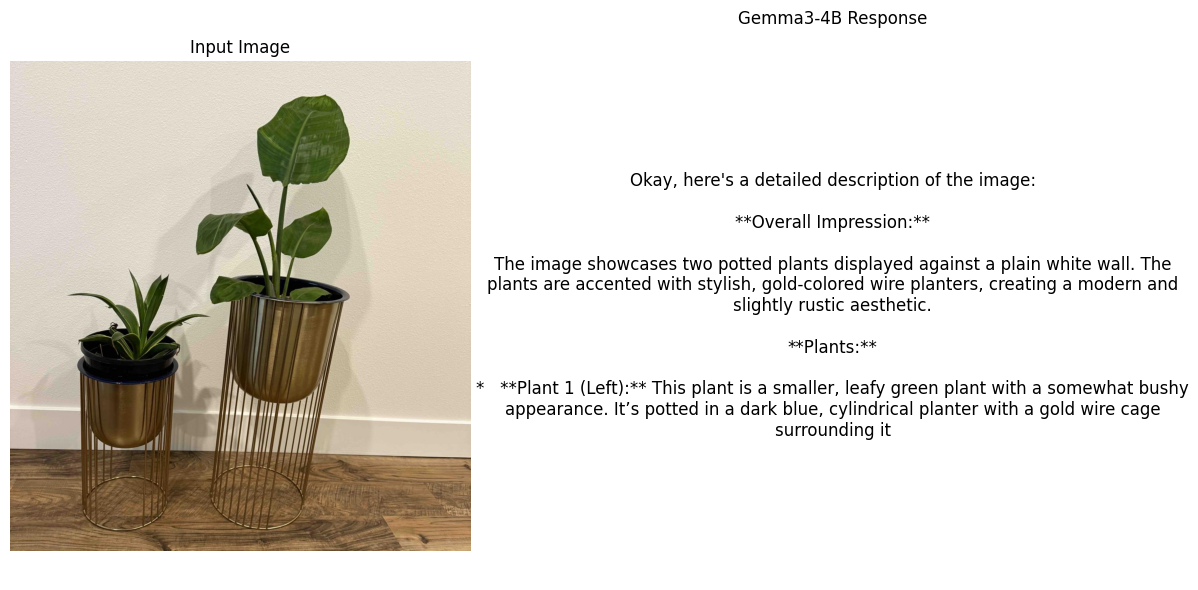

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image2)
axes[0].axis("off")
axes[0].set_title("Input Image")
axes[1].text(
    0.5, 0.5, decoded,
    fontsize=12, ha="center", va="center", wrap=True
)
axes[1].axis("off")
axes[1].set_title("Gemma3-4B Response")
plt.tight_layout()
plt.show()